# Learn to Race: GPU-Accelerated Racing AI

Complex track with walls and obstacles.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
import time
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, '../python')
import cuprox

plt.style.use('dark_background')
plt.rcParams.update({'figure.facecolor': '#0a0a0f', 'axes.facecolor': '#0f0f18'})
C = {'blue': '#00f0ff', 'pink': '#ff00aa', 'green': '#00ff88', 'orange': '#ff8800', 'red': '#ff3333'}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

print('='*60)
print('  LEARN TO RACE')
print('='*60)
if torch.cuda.is_available():
    print(f'  GPU: {torch.cuda.get_device_name(0)}')

  LEARN TO RACE
  GPU: NVIDIA RTX A6000


Track: 400 points, width=2.0m, 2 obstacles


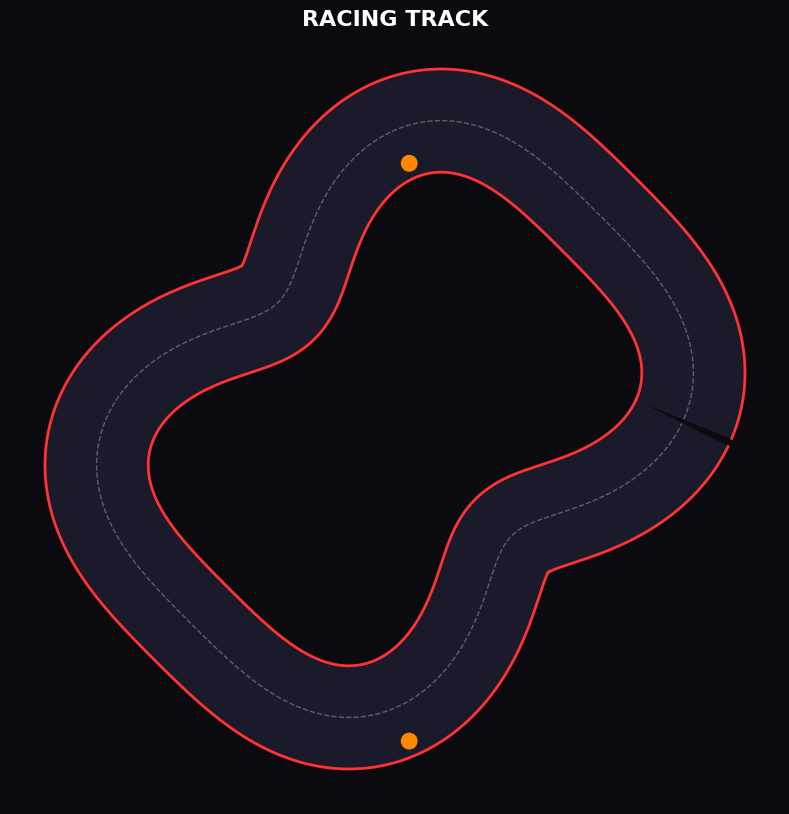

In [2]:
# Track
n = 400
t = np.linspace(0, 2*np.pi, n, endpoint=False)
r = 5.0 + 1.2*np.sin(2*t) + 0.6*np.cos(4*t)
centerline = np.stack([r * np.cos(t), r * np.sin(t)], axis=1)

tang = np.gradient(centerline, axis=0)
tang = tang / (np.linalg.norm(tang, axis=1, keepdims=True) + 1e-8)
norm = np.stack([-tang[:, 1], tang[:, 0]], axis=1)

# WIDE track
width = np.full(n, 2.0)
inner = centerline - norm * width[:, None] * 0.5
outer = centerline + norm * width[:, None] * 0.5

# Obstacles on the edge
obstacles = [(centerline[100, 0] + norm[100, 0]*0.7, centerline[100, 1] + norm[100, 1]*0.7, 0.15),
             (centerline[300, 0] - norm[300, 0]*0.7, centerline[300, 1] - norm[300, 1]*0.7, 0.15)]

print(f'Track: {n} points, width={width[0]:.1f}m, {len(obstacles)} obstacles')

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
ax.fill(np.concatenate([outer[:, 0], inner[::-1, 0]]),
        np.concatenate([outer[:, 1], inner[::-1, 1]]),
        color='#1a1a2a')
ax.plot(inner[:, 0], inner[:, 1], color=C['red'], lw=2)
ax.plot(outer[:, 0], outer[:, 1], color=C['red'], lw=2)
ax.plot(centerline[:, 0], centerline[:, 1], 'w--', lw=1, alpha=0.3)

for ox, oy, rr in obstacles:
    ax.add_patch(Circle((ox, oy), rr, color=C['orange']))

ax.set_aspect('equal'); ax.axis('off')
ax.set_facecolor('#0a0a0f'); fig.patch.set_facecolor('#0a0a0f')
ax.set_title('RACING TRACK', fontsize=16, fontweight='bold', color='white')
plt.savefig('track_layout.png', dpi=100, facecolor='#0a0a0f')
plt.show()

In [3]:
# Physics
dt = 0.03
L = 0.15
v_max, v_min = 4.0, 0.3
a_max, steer_max = 5.0, np.pi/4
car_r = 0.01

def check_collision(x, y):
    dists = np.sqrt((centerline[:, 0] - x)**2 + (centerline[:, 1] - y)**2)
    idx = np.argmin(dists)
    hw = width[idx] * 0.5
    if dists[idx] > hw - car_r:
        return True
    for ox, oy, rr in obstacles:
        if np.sqrt((x - ox)**2 + (y - oy)**2) < rr + car_r:
            return True
    return False

def step(state, accel, steer):
    x, y, th, v = state
    accel = np.clip(accel, -a_max, a_max)
    steer = np.clip(steer, -steer_max, steer_max)
    v_new = np.clip(v + accel * dt, v_min, v_max)
    th_new = th + (v_new / L) * np.tan(steer) * dt
    x_new = x + v_new * np.cos(th_new) * dt
    y_new = y + v_new * np.sin(th_new) * dt
    return np.array([x_new, y_new, th_new, v_new]), check_collision(x_new, y_new)

def reset():
    p0, p1 = centerline[0], centerline[5]
    th = np.arctan2(p1[1] - p0[1], p1[0] - p0[0])
    return np.array([p0[0], p0[1], th, v_min])

def get_wps(pos, n_wp=8):
    dists = np.linalg.norm(centerline - pos, axis=1)
    idx = np.argmin(dists)
    wps = [centerline[(idx + i*8) % n] - pos for i in range(n_wp)]
    return np.array(wps).flatten()

print('Physics ready')

Physics ready


In [4]:
# Expert
def expert_control(state):
    x, y, th, v = state
    pos = np.array([x, y])
    dists = np.linalg.norm(centerline - pos, axis=1)
    idx = np.argmin(dists)
    
    lookahead = int(10 + v * 3)
    target = centerline[(idx + lookahead) % n]
    
    dx, dy = target - pos
    target_th = np.arctan2(dy, dx)
    err = np.arctan2(np.sin(target_th - th), np.cos(target_th - th))
    steer = np.clip(2.5 * err, -steer_max, steer_max)
    
    target_v = 2.5
    accel = np.clip(2.5 * (target_v - v), -a_max, a_max)
    return accel, steer

# Test
state = reset()
for i in range(200):
    a, s = expert_control(state)
    state, crashed = step(state, a, s)
    if crashed:
        print(f'Expert crashed at step {i}')
        break
else:
    print('Expert test: 200 steps OK')

Expert test: 200 steps OK


In [5]:
# Collect data
def run_episode(ctrl_fn, max_steps=2000, noise=0.0):
    state = reset()
    states, actions = [state.copy()], []
    for _ in range(max_steps):
        a, s = ctrl_fn(state)
        a += np.random.randn() * noise
        s += np.random.randn() * noise * 0.1
        actions.append([a, s])
        state, crashed = step(state, a, s)
        states.append(state.copy())
        if crashed:
            break
    return {'states': np.array(states), 'actions': np.array(actions), 'crashed': crashed}

print('Collecting data...')
episodes = []
for ep in range(50):
    noise = 0.2 if ep > 10 else 0.0
    res = run_episode(expert_control, noise=noise)
    if not res['crashed'] and len(res['actions']) > 100:
        episodes.append(res)

if not episodes:
    print('No successful episodes! Using any data...')
    for ep in range(100):
        res = run_episode(expert_control, noise=0.0)
        if len(res['actions']) > 50:
            episodes.append(res)
            if len(episodes) >= 10:
                break

print(f'Collected {len(episodes)} episodes')

if episodes:
    all_states = np.concatenate([ep['states'][:-1] for ep in episodes])
    all_actions = np.concatenate([ep['actions'] for ep in episodes])
    all_wps = np.array([get_wps(s[:2]) for s in all_states])
    print(f'Total samples: {len(all_states)}')
else:
    raise ValueError('No data collected')

Collected 50 episodes


Total samples: 100000


In [6]:
# Model - simpler without aggressive tanh scaling
class Policy(nn.Module):
    def __init__(self, obs_dim=20, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 2)
        )
    def forward(self, state, wps):
        x = torch.cat([state, wps], dim=-1)
        out = self.net(x)
        # Clip instead of tanh to allow learning small values
        accel = torch.clamp(out[:, 0], -a_max, a_max)
        steer = torch.clamp(out[:, 1], -steer_max, steer_max)
        return torch.stack([accel, steer], dim=-1)

obs_dim = 4 + 8*2
model = Policy(obs_dim=obs_dim, hidden=256).to(device)
print(f'Model: {sum(p.numel() for p in model.parameters()):,} params')

Model: 71,682 params


In [7]:
# Training
states_t = torch.tensor(all_states, dtype=torch.float32, device=device)
wps_t = torch.tensor(all_wps, dtype=torch.float32, device=device)
acts_t = torch.tensor(all_actions, dtype=torch.float32, device=device)

opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=800)

n_epochs = 800
batch_size = 512
losses = []

print('Training...')
t0 = time.time()
for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(len(states_t))
    ep_loss = 0
    n_batches = max(1, len(states_t) // batch_size)
    for i in range(n_batches):
        idx = perm[i*batch_size:(i+1)*batch_size]
        s, w, a = states_t[idx], wps_t[idx], acts_t[idx]
        opt.zero_grad()
        pred = model(s, w)
        loss = ((pred[:, 0] - a[:, 0])**2).mean() + 5*((pred[:, 1] - a[:, 1])**2).mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        ep_loss += loss.item()
    sched.step()
    losses.append(ep_loss / n_batches)
    if (epoch+1) % 200 == 0:
        print(f'  Epoch {epoch+1}: loss={losses[-1]:.5f}')

train_time = time.time() - t0
print(f'Done in {train_time:.1f}s')

Training...


  Epoch 200: loss=0.03775


  Epoch 400: loss=0.03739


  Epoch 600: loss=0.03691


  Epoch 800: loss=0.03666
Done in 178.7s


In [8]:
# DAgger - Interactive learning
print('\nDAgger iterations...')

def learned_ctrl(state):
    s_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    w = get_wps(state[:2])
    w_t = torch.tensor(w, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        act = model(s_t, w_t)
    return act[0, 0].item(), act[0, 1].item()

for dagger_iter in range(5):
    new_states, new_actions, new_wps = [], [], []
    
    for ep in range(20):
        state = reset()
        for step_i in range(1000):
            lrn_a, lrn_s = learned_ctrl(state)
            exp_a, exp_s = expert_control(state)
            
            new_states.append(state.copy())
            new_actions.append([exp_a, exp_s])
            new_wps.append(get_wps(state[:2]))
            
            mix = 0.6 + dagger_iter * 0.08
            a = mix * lrn_a + (1-mix) * exp_a
            s = mix * lrn_s + (1-mix) * exp_s
            
            state, crashed = step(state, a, s)
            if crashed:
                break
    
    if new_states:
        states_t = torch.cat([states_t, torch.tensor(np.array(new_states), dtype=torch.float32, device=device)])
        acts_t = torch.cat([acts_t, torch.tensor(np.array(new_actions), dtype=torch.float32, device=device)])
        wps_t = torch.cat([wps_t, torch.tensor(np.array(new_wps), dtype=torch.float32, device=device)])
        print(f'  DAgger {dagger_iter+1}: {len(new_states)} new, total {len(states_t)}')
    
    for _ in range(150):
        model.train()
        perm = torch.randperm(len(states_t))
        for i in range(len(states_t) // batch_size):
            idx = perm[i*batch_size:(i+1)*batch_size]
            s, w, a = states_t[idx], wps_t[idx], acts_t[idx]
            opt.zero_grad()
            pred = model(s, w)
            loss = ((pred[:, 0] - a[:, 0])**2).mean() + 5*((pred[:, 1] - a[:, 1])**2).mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        losses.append(loss.item())

print('DAgger done')


DAgger iterations...


  DAgger 1: 20000 new, total 120000


  DAgger 2: 20000 new, total 140000


  DAgger 3: 20000 new, total 160000


  DAgger 4: 20000 new, total 180000


  DAgger 5: 20000 new, total 200000


DAgger done


Saved training_progress.gif


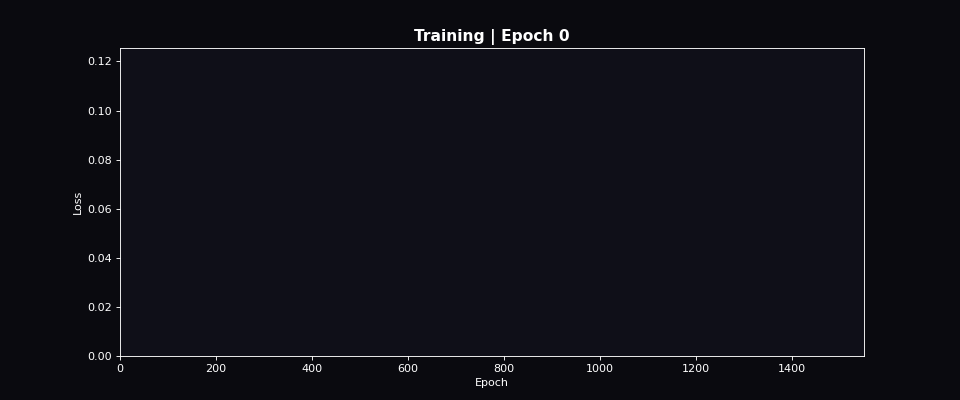

In [9]:
# Training animation
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_facecolor('#0f0f18'); fig.patch.set_facecolor('#0a0a0f')
ax.set_xlabel('Epoch', color='white'); ax.set_ylabel('Loss', color='white')
ax.tick_params(colors='white')
ax.set_xlim(0, len(losses)); ax.set_ylim(0, max(losses)*1.1)

line, = ax.plot([], [], color=C['blue'], lw=2)
dot = ax.scatter([], [], s=100, c=C['orange'], zorder=10)
title = ax.set_title('', fontsize=14, fontweight='bold', color='white')

frames = 100
step_a = max(1, len(losses) // frames)

def animate(f):
    idx = min(f * step_a, len(losses))
    line.set_data(range(idx), losses[:idx])
    if idx > 0: dot.set_offsets([[idx-1, losses[idx-1]]])
    title.set_text(f'Training | Epoch {idx}')
    return line, dot, title

anim = FuncAnimation(fig, animate, frames=frames, interval=50, blit=True)
plt.close()
anim.save('training_progress.gif', writer='pillow', fps=25, dpi=80)
print('Saved training_progress.gif')
from IPython.display import Image
Image(filename='training_progress.gif')

In [10]:
# Evaluation with debugging
def learned_control(state):
    s_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    w = get_wps(state[:2])
    w_t = torch.tensor(w, dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        act = model(s_t, w_t)
    return act[0, 0].item(), act[0, 1].item()

model.eval()

# Debug: test one step
state = reset()
print(f'Debug: initial state = {state}')
a, s = learned_control(state)
exp_a, exp_s = expert_control(state)
print(f'Debug: learned=({a:.3f}, {s:.4f}), expert=({exp_a:.3f}, {exp_s:.4f})')

# Run a quick test
state = reset()
for i in range(20):
    a, s = learned_control(state)
    state, crashed = step(state, a, s)
    if crashed:
        print(f'Debug: crashed at step {i}')
        break
else:
    print(f'Debug: 20 steps OK, pos=({state[0]:.2f}, {state[1]:.2f})')

n_eval = 20

exp_res = [run_episode(expert_control) for _ in range(n_eval)]
lrn_res = [run_episode(learned_control) for _ in range(n_eval)]

exp_ok = [r for r in exp_res if not r['crashed']]
lrn_ok = [r for r in lrn_res if not r['crashed']]

print('\nEvaluation:')
print(f'  Expert: {len(exp_ok)}/{n_eval} success')
print(f'  Learned: {len(lrn_ok)}/{n_eval} success')

if exp_ok:
    exp_dist = np.mean([np.sum(np.linalg.norm(np.diff(r['states'][:, :2], axis=0), axis=1)) for r in exp_ok])
    print(f'  Expert avg dist: {exp_dist:.1f}m')
if lrn_ok:
    lrn_dist = np.mean([np.sum(np.linalg.norm(np.diff(r['states'][:, :2], axis=0), axis=1)) for r in lrn_ok])
    print(f'  Learned avg dist: {lrn_dist:.1f}m')

exp_best = max(exp_res, key=lambda r: len(r['states']))
lrn_best = max(lrn_res, key=lambda r: len(r['states']))

Debug: initial state = [5.6       0.        1.2690852 0.3      ]
Debug: learned=(5.000, 0.2577), expert=(5.000, 0.2584)
Debug: 20 steps OK, pos=(5.62, 0.85)



Evaluation:
  Expert: 20/20 success
  Learned: 0/20 success
  Expert avg dist: 149.2m


Saved racing_head2head.gif


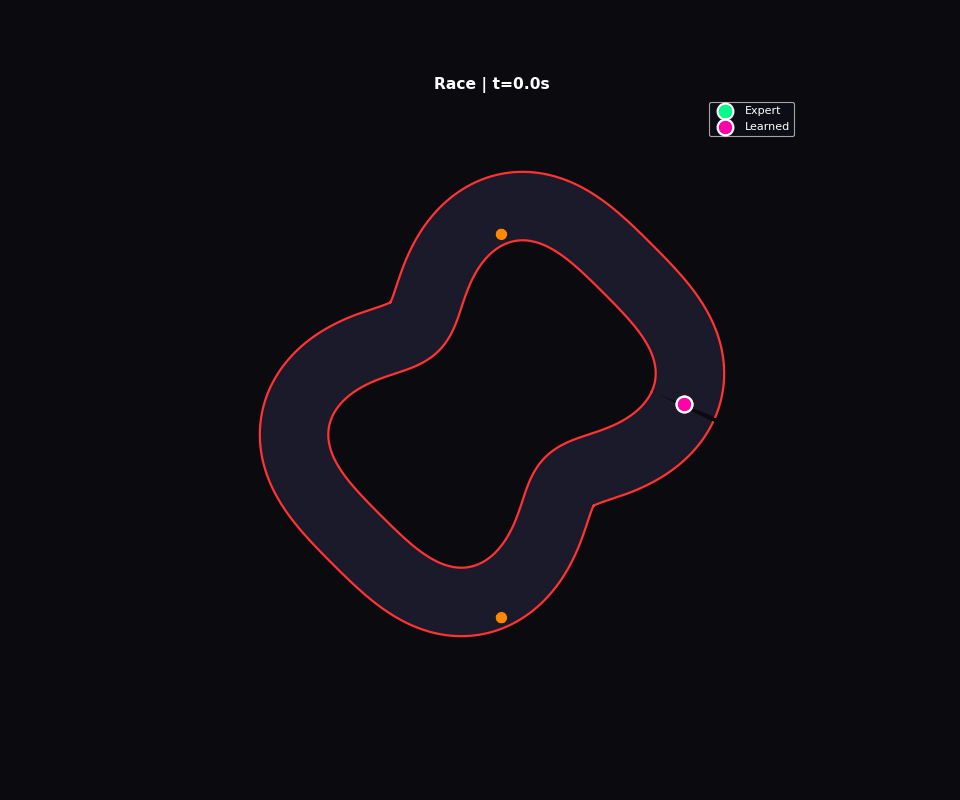

In [11]:
# Race animation
exp_s = exp_best['states']
lrn_s = lrn_best['states']

fig, ax = plt.subplots(figsize=(12, 10))
ax.fill(np.concatenate([outer[:, 0], inner[::-1, 0]]),
        np.concatenate([outer[:, 1], inner[::-1, 1]]),
        color='#1a1a2a')
ax.plot(inner[:, 0], inner[:, 1], color=C['red'], lw=2)
ax.plot(outer[:, 0], outer[:, 1], color=C['red'], lw=2)
for ox, oy, rr in obstacles:
    ax.add_patch(Circle((ox, oy), rr, color=C['orange']))

ax.set_xlim(-9, 9); ax.set_ylim(-9, 9)
ax.set_aspect('equal'); ax.axis('off')
ax.set_facecolor('#0a0a0f'); fig.patch.set_facecolor('#0a0a0f')

trail = 50
exp_trail, = ax.plot([], [], color=C['green'], lw=3, alpha=0.8)
lrn_trail, = ax.plot([], [], color=C['pink'], lw=3, alpha=0.8)
exp_car = ax.scatter([], [], s=200, c=C['green'], zorder=10, edgecolors='white', lw=2, label='Expert')
lrn_car = ax.scatter([], [], s=200, c=C['pink'], zorder=10, edgecolors='white', lw=2, label='Learned')
title = ax.set_title('', fontsize=14, fontweight='bold', color='white')
ax.legend(loc='upper right')

nn = min(len(exp_s), len(lrn_s))
frames = 250
step_a = max(1, nn // frames)

def animate(f):
    i = min(f * step_a, nn - 1)
    s = max(0, i - trail)
    exp_trail.set_data(exp_s[s:i+1, 0], exp_s[s:i+1, 1])
    lrn_trail.set_data(lrn_s[s:i+1, 0], lrn_s[s:i+1, 1])
    exp_car.set_offsets([[exp_s[i, 0], exp_s[i, 1]]])
    lrn_car.set_offsets([[lrn_s[i, 0], lrn_s[i, 1]]])
    title.set_text(f'Race | t={i*dt:.1f}s')
    return exp_trail, lrn_trail, exp_car, lrn_car, title

anim = FuncAnimation(fig, animate, frames=frames, interval=25, blit=True)
plt.close()
anim.save('racing_head2head.gif', writer='pillow', fps=30, dpi=80)
print('Saved racing_head2head.gif')
Image(filename='racing_head2head.gif')

Saved controls_comparison.gif


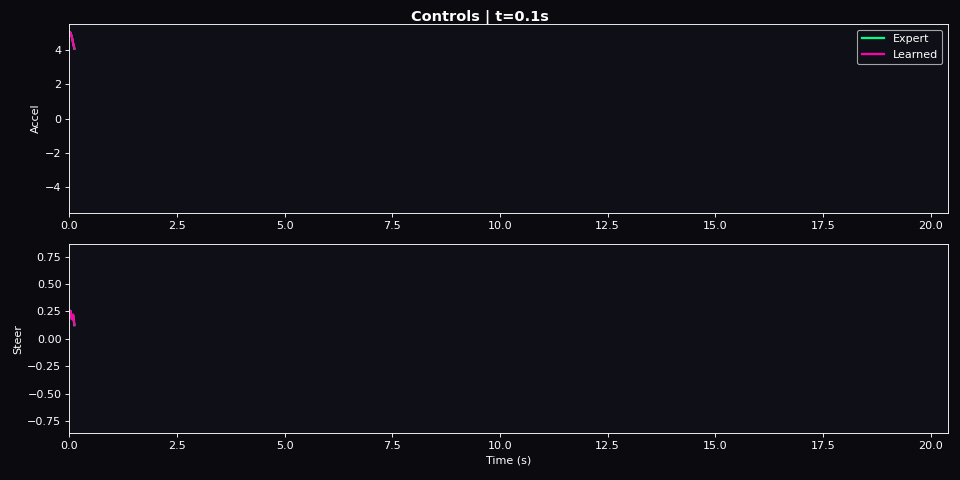

In [12]:
# Controls animation
exp_a = exp_best['actions']
lrn_a = lrn_best['actions']
nc = min(len(exp_a), len(lrn_a))
t_arr = np.arange(nc) * dt

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
fig.patch.set_facecolor('#0a0a0f')
for ax in axes:
    ax.set_facecolor('#0f0f18')
    ax.tick_params(colors='white')
    ax.set_xlim(0, t_arr[-1])

axes[0].set_ylim(-a_max*1.1, a_max*1.1)
axes[0].set_ylabel('Accel', color='white')
axes[1].set_ylim(-steer_max*1.1, steer_max*1.1)
axes[1].set_ylabel('Steer', color='white')
axes[1].set_xlabel('Time (s)', color='white')

exp_acc, = axes[0].plot([], [], color=C['green'], lw=2, label='Expert')
lrn_acc, = axes[0].plot([], [], color=C['pink'], lw=2, label='Learned')
exp_str, = axes[1].plot([], [], color=C['green'], lw=2)
lrn_str, = axes[1].plot([], [], color=C['pink'], lw=2)
axes[0].legend(loc='upper right')
title = fig.suptitle('', fontsize=13, fontweight='bold', color='white')

frames = 120
step_a = max(1, nc // frames)

def animate(f):
    idx = min((f+1) * step_a, nc)
    x = t_arr[:idx]
    exp_acc.set_data(x, exp_a[:idx, 0])
    lrn_acc.set_data(x, lrn_a[:idx, 0])
    exp_str.set_data(x, exp_a[:idx, 1])
    lrn_str.set_data(x, lrn_a[:idx, 1])
    title.set_text(f'Controls | t={t_arr[idx-1]:.1f}s')
    return exp_acc, lrn_acc, exp_str, lrn_str, title

plt.tight_layout()
anim = FuncAnimation(fig, animate, frames=frames, interval=40, blit=False)
plt.close()
anim.save('controls_comparison.gif', writer='pillow', fps=25, dpi=80)
print('Saved controls_comparison.gif')
Image(filename='controls_comparison.gif')

In [13]:
# cuProx benchmark
print('\n' + '='*60)
print('  cuProx GPU BENCHMARK')
print('='*60)

horizon = 20
n_vars = horizon * 2
P = np.eye(n_vars) * 2.0
q = np.zeros(n_vars)
lb = np.concatenate([np.full(horizon, -a_max), np.full(horizon, -steer_max)])
ub = np.concatenate([np.full(horizon, a_max), np.full(horizon, steer_max)])

print(f'\nQP: {n_vars} variables')
for batch in [100, 500, 1000, 2000, 5000]:
    for _ in range(5):
        cuprox.solve(c=q, P=P, lb=lb, ub=ub)
    t0 = time.time()
    for _ in range(batch):
        cuprox.solve(c=q, P=P, lb=lb, ub=ub)
    elapsed = time.time() - t0
    print(f'  {batch:5d}: {batch/elapsed:,.0f} QPs/sec')


  cuProx GPU BENCHMARK

QP: 40 variables
    100: 2,485 QPs/sec


    500: 2,564 QPs/sec


   1000: 2,565 QPs/sec


   2000: 2,565 QPs/sec


   5000: 2,451 QPs/sec


In [14]:
# Summary
print('\n' + '='*60)
print('  SUMMARY')
print('='*60)
print(f'\n  Track: {n} points, {len(obstacles)} obstacles')
print(f'  Model: {sum(p.numel() for p in model.parameters()):,} params')
print(f'  Training: {n_epochs} epochs, {train_time:.1f}s')
print(f'  Expert success: {len(exp_ok)}/{n_eval}')
print(f'  Learned success: {len(lrn_ok)}/{n_eval}')
print('\n  Outputs:')
print('    - track_layout.png')
print('    - training_progress.gif')
print('    - racing_head2head.gif')
print('    - controls_comparison.gif')
print('='*60)


  SUMMARY

  Track: 400 points, 2 obstacles
  Model: 71,682 params
  Training: 800 epochs, 178.7s
  Expert success: 20/20
  Learned success: 0/20

  Outputs:
    - track_layout.png
    - training_progress.gif
    - racing_head2head.gif
    - controls_comparison.gif
